<a href="https://colab.research.google.com/github/hsari87/Pilot-Data-Analysis/blob/main/Final_Adaptive_Spelling_4_6_Simulation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#Change runtime to R again. And, then run the following
install.packages("mirt")
install.packages("dplyr")
install.packages("ggplot2")

library(mirt)
library(dplyr)
library(ggplot2)


Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘globals’, ‘R.oo’, ‘parallelly’, ‘beepr’, ‘future’, ‘future.apply’, ‘progressr’, ‘R.utils’, ‘gridExtra’, ‘vegan’, ‘pbapply’, ‘dcurver’, ‘SimDesign’, ‘RcppArmadillo’


Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Loading required package: stats4

Loading required package: lattice


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union




In [2]:
# --- Install and Load Required Packages ---
# The 'bigrquery' package is used to interact with Google BigQuery.
# 'dplyr' is a powerful data manipulation package.
# 'lubridate' is for working with dates and times.
if (!requireNamespace("bigrquery", quietly = TRUE)) {
  install.packages("bigrquery")
}
if (!requireNamespace("dplyr", quietly = TRUE)) {
  install.packages("dplyr")
}
if (!requireNamespace("lubridate", quietly = TRUE)) {
  install.packages("lubridate")
}

library(bigrquery)
library(dplyr)
library(lubridate)

# Authenticate with Google Cloud
# You might need to run `bigrquery::bq_auth()` the first time
# or set environment variables for authentication

# Set your project ID and table reference
project_id <- "marker-prod-5e18"
table_ref <- "marker-prod-5e18.data_science.combo_spelling"

# Construct the SQL query
sql_query <- paste0("SELECT * FROM `", table_ref, "`")

# Query BigQuery and load data into a data frame
comprehensive_results <- bq_project_query(project_id, sql_query) %>%
  bq_table_download()

# Print data frame dimensions

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘clock’, ‘nanoparquet’, ‘rapidjsonr’



Attaching package: ‘lubridate’


The following objects are masked from ‘package:base’:

    date, intersect, setdiff, union


Is it OK to cache OAuth access credentials in the folder ~/.cache/gargle
between R sessions?
1: Yes
2: No


Selection: 1


Please point your browser to the following url: 

https://accounts.google.com/o/oauth2/v2/auth?client_id=603366585132-frjlouoa3s2ono25d2l9ukvhlsrlnr7k.apps.googleusercontent.com&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fbigquery%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fcloud-platform%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fuserinfo.email&redirect_uri=https%3A%2F%2Fwww.tidyverse.org%2Fgoogle-callback%2F&response_type=code&state=932fcadb553287a8e89fb1546ac9a515&access_type=offline&prompt=consent



Enter authorization code: eyJjb2RlIjoiNC8wQVZHelIxRGZQY1c0M2ZTZGlDWjhEVVlVMXdOM2N5VUJOUkl3bVVKYUVsRDg4WjB0aURVOGtOY2MwemEwWG9oc0U5Y2VKUSIsInN0YXRlIjoiOTMyZmNhZGI1NTMyODdhOGU4OWZiMTU0NmFjOWE1MTUifQ==


In [36]:
data <- comprehensive_results
head(data)

UUID,is_uuid_2,Age,Grade,EXCLUDE_RESULTS,resultsValid_in_app,invalidated_in_survey,feedback_end_early,finishedEarly_reasons,total_questions,⋯,SP118_answer,SP118_correct,SP118_didnt_know,SP118_time_elapsed,SP118_assigned,SP119_answer,SP119_correct,SP119_didnt_know,SP119_time_elapsed,SP119_assigned
<chr>,<lgl>,<chr>,<chr>,<lgl>,<chr>,<lgl>,<chr>,<chr>,<int>,⋯,<chr>,<lgl>,<lgl>,<dbl>,<lgl>,<chr>,<lgl>,<lgl>,<dbl>,<lgl>
dc74f713-e75b-4a66-b4a3-11d9e7a0b23e,FALSE,11,5th,FALSE,NA,FALSE,,,32,⋯,NA,NA,NA,NA,FALSE,NA,NA,NA,NA,FALSE
22fd7856-71c0-40ea-8ad9-93bd59598469,FALSE,10,3rd,FALSE,NA,FALSE,,,11,⋯,NA,NA,NA,NA,FALSE,NA,NA,NA,NA,FALSE
84eb3664-6328-4ffc-b181-1e04c796d987,FALSE,7,1st,FALSE,NA,FALSE,,,16,⋯,NA,NA,NA,NA,FALSE,NA,NA,NA,NA,FALSE
0583b7dc-ea8a-43af-bdbc-cd6df2de24b4,FALSE,8,2nd,FALSE,NA,FALSE,,,32,⋯,NA,NA,NA,NA,FALSE,NA,NA,NA,NA,FALSE
13aaa63b-727c-4ac6-905b-91644fc82885,FALSE,5,PK,FALSE,NA,FALSE,,,4,⋯,NA,NA,NA,NA,FALSE,NA,NA,NA,NA,FALSE
1fff8d1f-1713-4191-8924-c0d8593a4005,FALSE,5,PK,FALSE,NA,FALSE,,,5,⋯,NA,NA,NA,NA,FALSE,NA,NA,NA,NA,FALSE


In [37]:

# Step 2: Select relevant columns
data_selected <- data %>%
  select(UUID, Age, Grade, matches("_correct$")) %>%
  mutate(UUID = as.character(UUID))


In [38]:

# Step 3: Convert "False" string entries to logical FALSE
data_selected <- data_selected %>%
  mutate(across(starts_with('SP'), ~ ifelse(. == "False", FALSE, .)))

In [39]:

# Step 4: Define which items each grade should have seen
grade_items <- list(
  'PK' = paste0('SP', 1:16, '_correct'),
  'Kindergarten' = paste0('SP', 1:16, '_correct'),
  '1st' = paste0('SP', 1:24, '_correct'),
  '2nd' = paste0('SP', 9:32, '_correct'),
  '3rd' = paste0('SP', 17:40, '_correct'),
  '4th' = paste0('SP', 25:48, '_correct'),
  '5th' = paste0('SP', 33:56, '_correct'),
  '6th' = paste0('SP', 41:64, '_correct'),
  '7th' = paste0('SP', 49:72, '_correct'),
  '8th' = paste0('SP', 57:80, '_correct'),
  '9th' = paste0('SP', 65:88, '_correct'),
  '10th' = paste0('SP', 73:96, '_correct'),
  '11th' = paste0('SP', 81:104, '_correct'),
  '12th' = paste0('SP', 89:104, '_correct'),
  'College' = paste0('SP', 89:104, '_correct')
)

In [40]:

# Step 5: Mark unattempted administered items as FALSE
for (gr in names(grade_items)) {
  items <- grade_items[[gr]]
  data_selected[data_selected$Grade == gr, items] <- data_selected[data_selected$Grade == gr, items] %>%
    mutate(across(everything(), ~ ifelse(. == "" | is.na(.), FALSE, .)))
}


In [41]:

# Step 6: Convert responses to numeric 0/1
data_selected <- data_selected %>%
  mutate(across(starts_with('SP'), as.logical))


In [42]:
# Save metadata before numeric conversion
metadata <- data_selected[, c("UUID", "Grade")]

# Convert TRUE/FALSE to 0/1 for item data
df_items <- data_selected[, grep("^SP\\d+_correct", names(data_selected))]
df_items_numeric <- as.data.frame(lapply(df_items, function(x) as.numeric(as.logical(x))))


In [43]:
# -------------------------------
# Step 1: Subset to Grades 4-6
# -------------------------------
grades_to_include <- c("4th", "5th", "6th", "7th", "8th") # I selected the responses from 4 different grades because we needed more number of medium and hard items

subset_metadata <- metadata %>% filter(Grade %in% grades_to_include)
subset_items    <- df_items_numeric[metadata$Grade %in% grades_to_include, ]

# -------------------------------
# Step 2: Select items SP33–SP72   (4th-8th gr content). I did not select 3rd gr content because we had enough number of easy items
# -------------------------------
item_cols <- paste0("SP", 33:72, "_correct") #(4th-8th gr content)
subset_items <- subset_items[, item_cols]

# -------------------------------
# Step 3: Fit Rasch Model
# -------------------------------
rasch_model <- mirt(subset_items, 1, itemtype = "Rasch", verbose = FALSE)

# -------------------------------
# Step 4: Extract Item Parameters
# -------------------------------
b_values <- coef(rasch_model, IRTpars = TRUE, simplify = TRUE)$items[, "b"]
print(b_values)


SP33_correct SP34_correct SP35_correct SP36_correct SP37_correct SP38_correct 
 -5.29897973  -2.04187352  -3.14821028  -2.38518376  -0.84309257  -1.71858973 
SP39_correct SP40_correct SP41_correct SP42_correct SP43_correct SP44_correct 
 -1.71858973   0.87538469   1.69004480   6.12361653   2.50238378   0.27367111 
SP45_correct SP46_correct SP47_correct SP48_correct SP49_correct SP50_correct 
 -3.87316458  -2.56087672  -2.12532168  -0.07102502  -2.57872938  -2.29366310 
SP51_correct SP52_correct SP53_correct SP54_correct SP55_correct SP56_correct 
 -2.57872938  -1.24949690   1.14150020   2.00931170  -0.78287695   0.05152896 
SP57_correct SP58_correct SP59_correct SP60_correct SP61_correct SP62_correct 
  1.42491316  -2.19077089   0.66915720  -0.11113205   2.46341623   1.67696990 
SP63_correct SP64_correct SP65_correct SP66_correct SP67_correct SP68_correct 
  1.93217244   0.92244918  -3.04599703   2.56989500  -1.30459444  -3.04599703 
SP69_correct SP70_correct SP71_correct SP72_correct 

In [44]:

# -------------------------------
# Step 6: Person Ability Estimates for all 4th-8th graders
# -------------------------------
theta_scores <- fscores(rasch_model, method = "EAP")[,1]

person_info <- data.frame(
  UUID  = subset_metadata$UUID,
  Grade = subset_metadata$Grade,
  Theta = theta_scores
)

head(person_info)

,UUID,Grade,Theta
,<chr>,<chr>,<dbl>
1,dc74f713-e75b-4a66-b4a3-11d9e7a0b23e,5th,0.5461246
2,1150ba8c-62af-41e6-8145-d8de2acae86e,5th,1.3444629
3,8f7b3ec6-366d-43f4-8953-054d540359dd,6th,3.1235219
4,8e5d13ca-14c0-4a7d-a47f-a8f93942c8f0,4th,-2.9119053
5,5599f1ba-9a80-43a0-b7eb-c0b724e99113,5th,-1.0449531
6,cc7efab9-0d54-4355-83e1-4ae7017dd41c,5th,2.3827831


In [45]:
# Summary statistics for b values (items SP33–SP72)
b_summary <- list(
  min    = min(b_values, na.rm = TRUE),
  max    = max(b_values, na.rm = TRUE),
  range  = diff(range(b_values, na.rm = TRUE)),
  mean   = mean(b_values, na.rm = TRUE),
  sd     = sd(b_values, na.rm = TRUE),
  median = median(b_values, na.rm = TRUE),
  q10    = quantile(b_values, 0.10, na.rm = TRUE),
  q25    = quantile(b_values, 0.25, na.rm = TRUE),
  q75    = quantile(b_values, 0.75, na.rm = TRUE),
  q90    = quantile(b_values, 0.90, na.rm = TRUE)
)

print(lapply(b_summary, function(x) round(x, 3)))


$min
[1] -5.299

$max
[1] 6.124

$range
[1] 11.423

$mean
[1] -0.283

$sd
[1] 2.348

$median
[1] -0.091

$q10
   10% 
-3.046 

$q25
   25% 
-2.216 

$q75
 75% 
1.68 

$q90
  90% 
2.467 



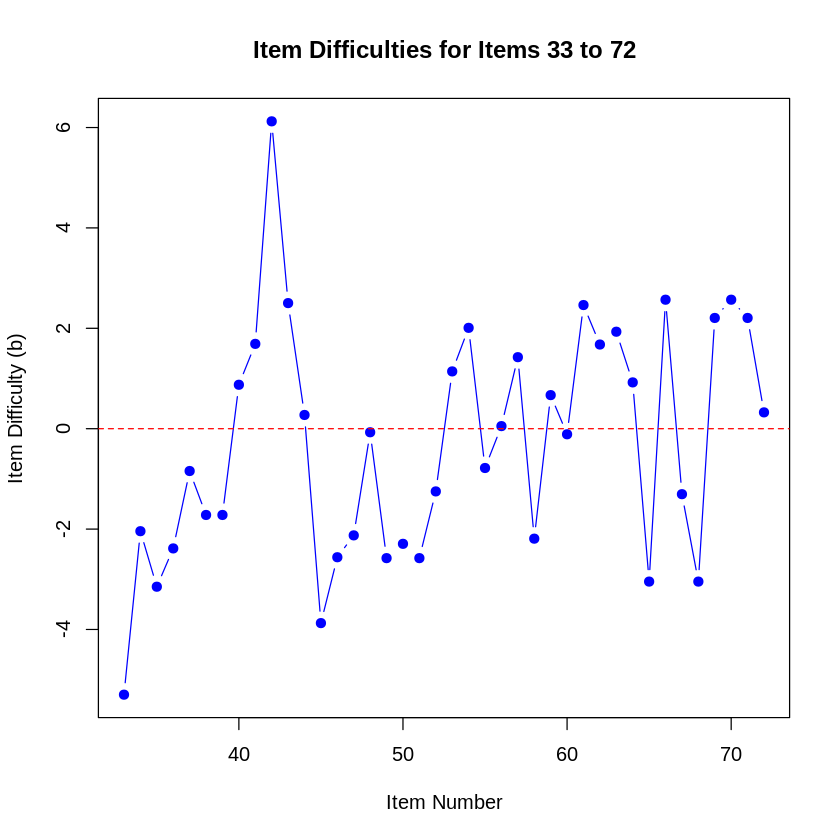

In [46]:
# Plot b values 4th-8th grade items

# Create a basic plot
plot(33:72, b_values,
     type = "b",
     pch = 19,
     col = "blue",
     xlab = "Item Number",
     ylab = "Item Difficulty (b)",
     main = "Item Difficulties for Items 33 to 72")

# Add horizontal reference line at 0 (average theta level)
abline(h = 0, col = "red", lty = 2)


In [47]:

# If theta_scores is a matrix or data frame, extract the first column
theta_values <- as.numeric(theta_scores)

# Summary statistics for theta values
theta_summary <- list(
  min    = min(theta_values, na.rm = TRUE),
  max    = max(theta_values, na.rm = TRUE),
  range  = diff(range(theta_values, na.rm = TRUE)),
  mean   = mean(theta_values, na.rm = TRUE),
  sd     = sd(theta_values, na.rm = TRUE),
  median = median(theta_values, na.rm = TRUE),
  q10    = quantile(theta_values, 0.10, na.rm = TRUE),
  q25    = quantile(theta_values, 0.25, na.rm = TRUE),
  q75    = quantile(theta_values, 0.75, na.rm = TRUE),
  q90    = quantile(theta_values, 0.90, na.rm = TRUE)
)

# Round and print
theta_summary_rounded <- lapply(theta_summary, function(x) round(x, 3))
print(theta_summary_rounded)

$min
[1] -5.236

$max
[1] 4.73

$range
[1] 9.966

$mean
[1] 0.106

$sd
[1] 2.6

$median
[1] 0.546

$q10
   10% 
-3.673 

$q25
   25% 
-1.781 

$q75
  75% 
1.944 

$q90
  90% 
3.101 



In [48]:
# Descriptive statistics for theta values by Grade
grade_theta_summary <- person_info %>%
  group_by(Grade) %>%
  summarise(
    n      = n(),
    min    = min(Theta, na.rm = TRUE),
    max    = max(Theta, na.rm = TRUE),
    mean   = mean(Theta, na.rm = TRUE),
    sd     = sd(Theta, na.rm = TRUE),
    median = median(Theta, na.rm = TRUE),
    q10    = quantile(Theta, 0.10, na.rm = TRUE),
    q25    = quantile(Theta, 0.25, na.rm = TRUE),
    q75    = quantile(Theta, 0.75, na.rm = TRUE),
    q90    = quantile(Theta, 0.90, na.rm = TRUE)
  )

# Print the summary
print(grade_theta_summary)

# A tibble: 5 × 11
  Grade     n   min   max   mean    sd median   q10     q25    q75   q90
  <chr> <int> <dbl> <dbl>  <dbl> <dbl>  <dbl> <dbl>   <dbl>  <dbl> <dbl>
1 4th      13 -4.62  4.71 -0.205  2.68 -1.13  -2.73 -2.00   1.66    3.43
2 5th      22 -5.24  4.00  0.285  2.68  1.14  -3.81 -0.735  1.82    3.10
3 6th      13 -3.58  3.12 -0.762  2.10 -0.516 -2.61 -2.61   0.0880  2.31
4 7th      11 -4.75  4.73  0.858  3.16  1.97  -4.75 -0.0154 2.63    3.02
5 8th       9 -4.33  3.93  0.452  2.34  0.781 -1.33 -0.577  1.93    2.33


we should closely monitor 4th, 5th and 6th graders' theta values

In [49]:
# Get number of theta scores (i.e., persons estimated)
length(theta_scores)


[1] 68

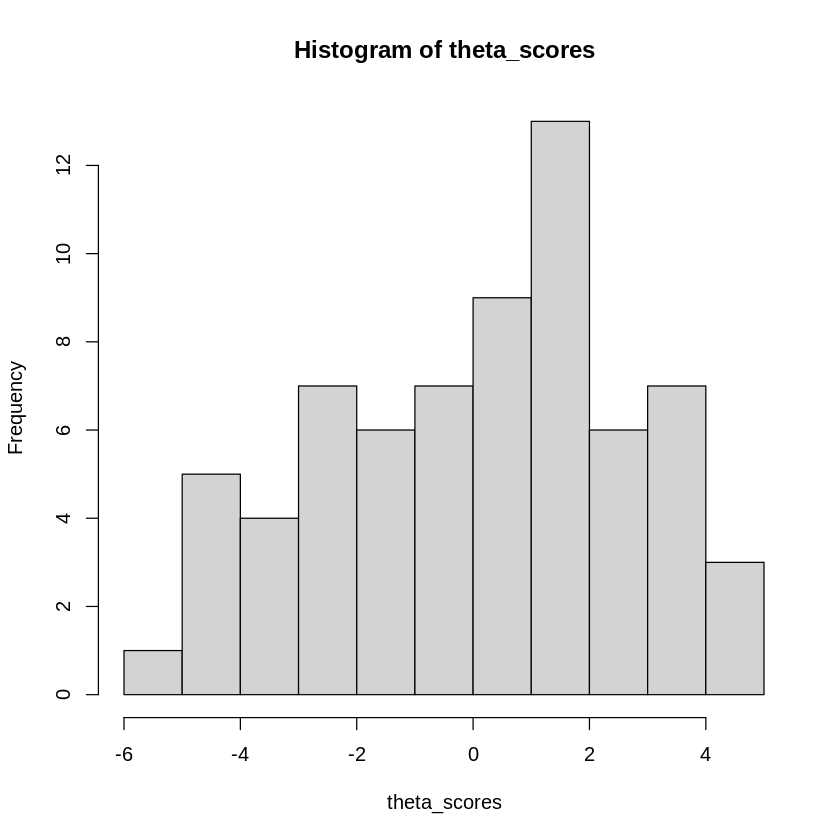

In [50]:
hist(theta_scores) # theta params for all

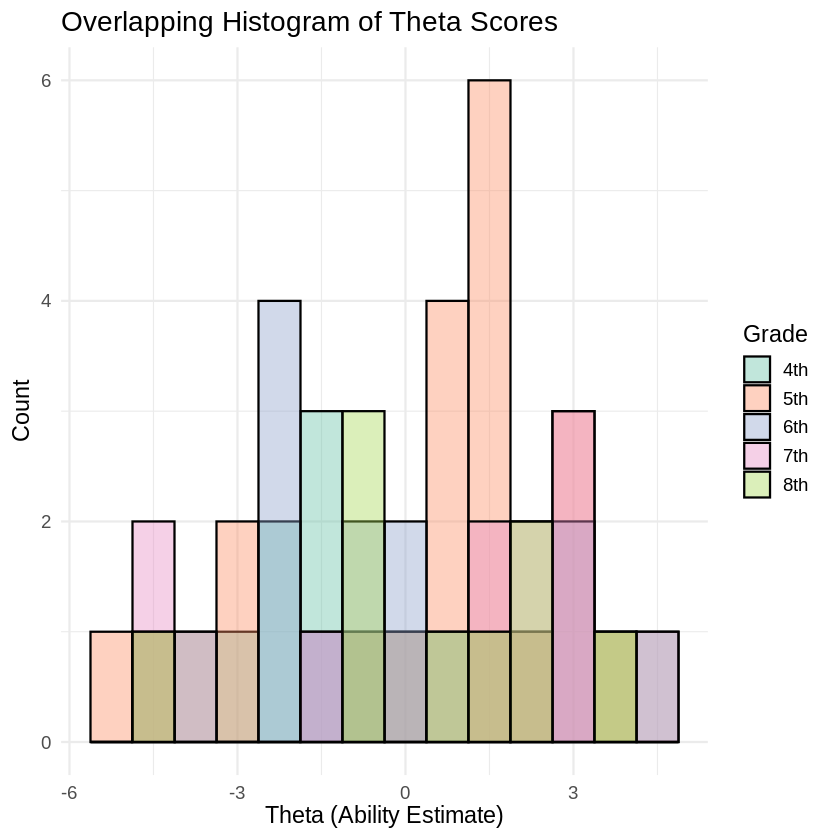

In [51]:
ggplot(person_info, aes(x = Theta, fill = Grade)) +
  geom_histogram(position = "identity", alpha = 0.4, binwidth = 0.75, color = "black") +
  labs(title = "Overlapping Histogram of Theta Scores",
       x = "Theta (Ability Estimate)",
       y = "Count") +
  theme_minimal(base_size = 14) +
  scale_fill_brewer(palette = "Set2")


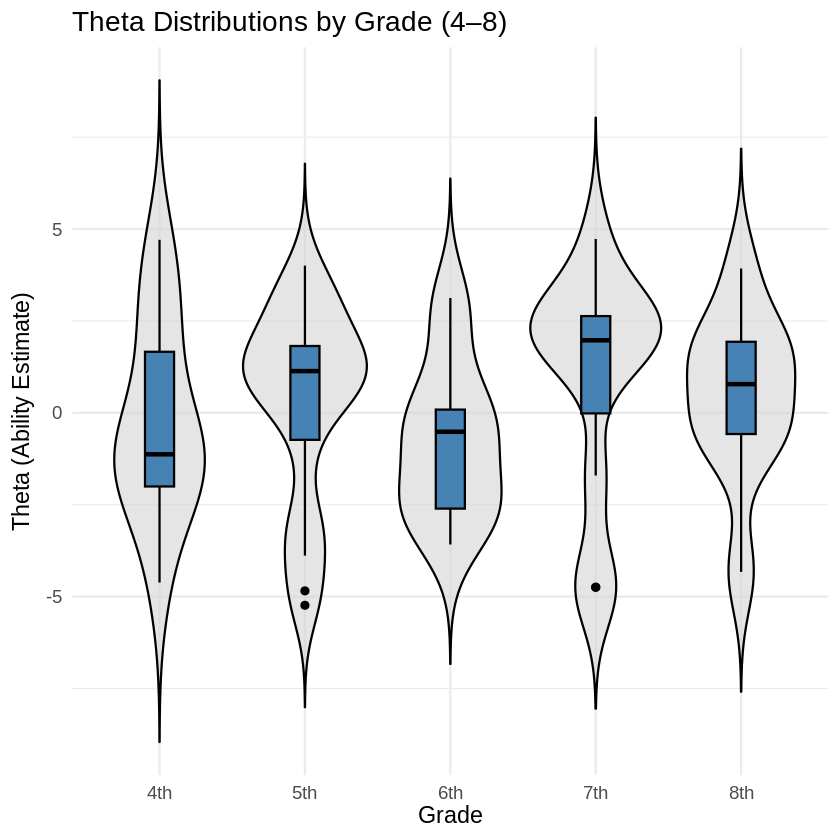

In [52]:
ggplot(person_info, aes(x = Grade, y = Theta)) +
  geom_violin(fill = "lightgray", color = "black", alpha = 0.6, trim = FALSE) +
  geom_boxplot(width = 0.2, fill = "steelblue", color = "black") +
  labs(title = "Theta Distributions by Grade (4–8)",
       x = "Grade",
       y = "Theta (Ability Estimate)") +
  theme_minimal(base_size = 14)


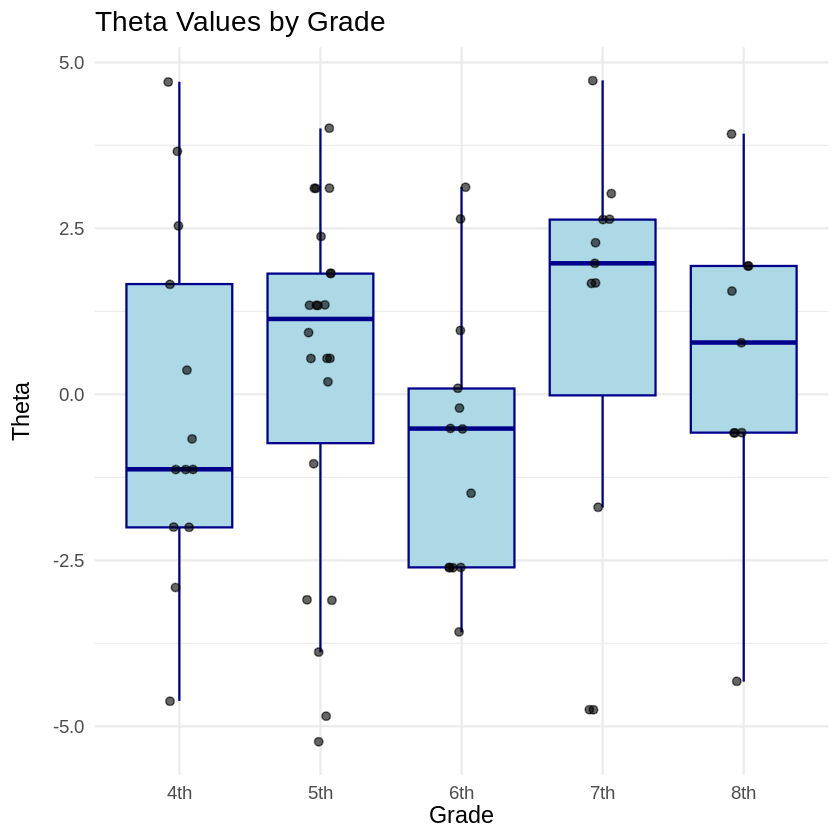

In [53]:
ggplot(person_info, aes(x = Grade, y = Theta)) +
  geom_boxplot(fill = "lightblue", color = "darkblue", outlier.shape = NA) +
  geom_jitter(width = 0.1, alpha = 0.6, color = "black") +
  labs(title = "Theta Values by Grade",
       x = "Grade",
       y = "Theta") +
  theme_minimal(base_size = 14)


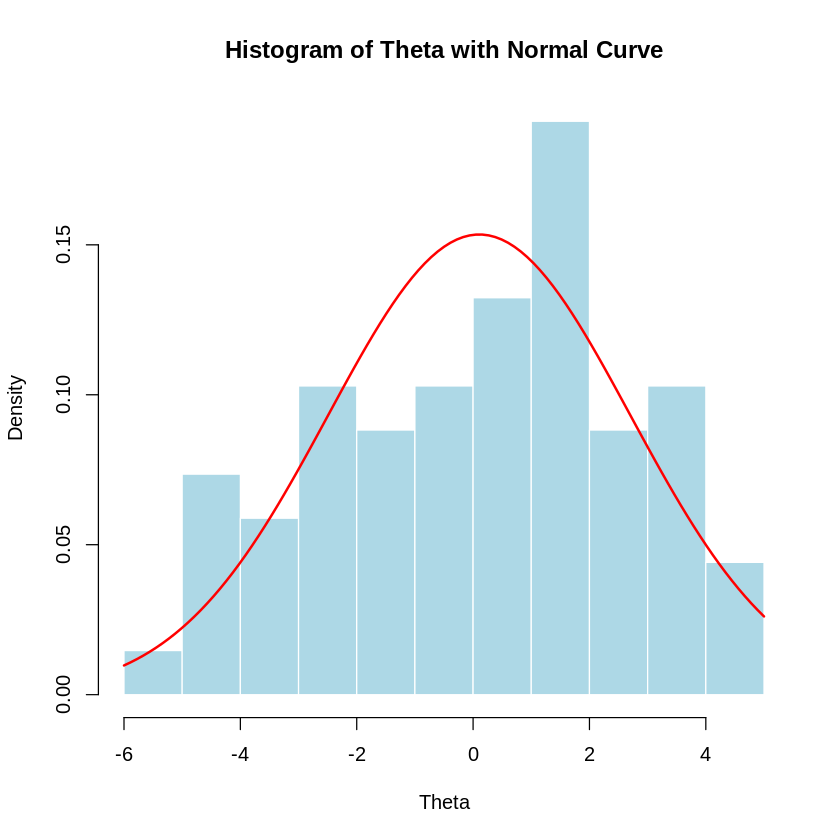

In [54]:
## plot all theta values

hist(person_info$Theta,
     prob = TRUE,
     col = "lightblue",
     border = "white",
     main = "Histogram of Theta with Normal Curve",
     xlab = "Theta")

curve(dnorm(x,
            mean = mean(person_info$Theta),
            sd = sd(person_info$Theta)),
      col = "red",
      lwd = 2,
      add = TRUE)


In [55]:
# Define bins and labels to see number of items in each interval
difficulty_bin <- cut(b_values,
                      breaks = c(-Inf,-5, -4.5, -4,-3.5, -3, -2.0, -1.5, -1, -0.5, 0, 0.5 ,1.0, 1.5, 2, 2.5, 3, 3.5, 4, 4.5, 5, Inf),
                                           right = FALSE)

# Count items in each bin
table(difficulty_bin)

difficulty_bin
[-Inf,-5) [-5,-4.5) [-4.5,-4) [-4,-3.5) [-3.5,-3)   [-3,-2) [-2,-1.5) [-1.5,-1) 
        1         0         0         1         3         8         2         2 
[-1,-0.5)  [-0.5,0)   [0,0.5)   [0.5,1)   [1,1.5)   [1.5,2)   [2,2.5)   [2.5,3) 
        2         2         3         3         2         3         4         3 
  [3,3.5)   [3.5,4)   [4,4.5)   [4.5,5)  [5, Inf) 
        0         0         0         0         1 

In [56]:
install.packages("tibble")
library(tibble)
install.packages("stringr")
library(stringr)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



In [57]:
# ---- 1. Create item pool data frame ----
pool_33_72 <- data.frame(
  item_id = names(b_values),
  b = as.numeric(b_values),
  stringsAsFactors = FALSE
)

# ---- 2. Assign difficulty bins ----
library(dplyr)

pool_33_72 <- pool_33_72 %>%
  mutate(bin_theta = case_when(
    b < -3 ~ "Very Easy",
    b >= -3 & b < -1.5 ~ "Easy",
    b >= -1.5 & b <= 1.5 ~ "Medium",
    b > 1.5 ~ "Hard"
  ))

# ---- 3. Print summary counts ----
cat("Summary of Items by Difficulty Bin:\n")
print(table(pool_33_72$bin_theta))

# ---- 4. Print sorted item table ----
cat("\nDetailed Item Classification:\n")
pool_33_72 %>%
  arrange(b) %>%
  select(item_id, b, bin_theta) %>%
  tibble::as_tibble() %>%
  print(n = Inf)


Summary of Items by Difficulty Bin:

     Easy      Hard    Medium Very Easy 
       10        11        14         5 

Detailed Item Classification:
# A tibble: 40 × 3
   item_id            b bin_theta
   <chr>          <dbl> <chr>    
 1 SP33_correct -5.30   Very Easy
 2 SP45_correct -3.87   Very Easy
 3 SP35_correct -3.15   Very Easy
 4 SP65_correct -3.05   Very Easy
 5 SP68_correct -3.05   Very Easy
 6 SP49_correct -2.58   Easy     
 7 SP51_correct -2.58   Easy     
 8 SP46_correct -2.56   Easy     
 9 SP36_correct -2.39   Easy     
10 SP50_correct -2.29   Easy     
11 SP58_correct -2.19   Easy     
12 SP47_correct -2.13   Easy     
13 SP34_correct -2.04   Easy     
14 SP38_correct -1.72   Easy     
15 SP39_correct -1.72   Easy     
16 SP67_correct -1.30   Medium   
17 SP52_correct -1.25   Medium   
18 SP37_correct -0.843  Medium   
19 SP55_correct -0.783  Medium   
20 SP60_correct -0.111  Medium   
21 SP48_correct -0.0710 Medium   
22 SP56_correct  0.0515 Medium   
23 SP44_correct

In [58]:
# ---- 1. Rasch Test Information Function (Vectorized) ----
rasch_test_info <- function(theta, b_params) {
  if (length(b_params) == 0) {
    return(rep(0, length(theta)))  # No items in bin → flat 0 info
  }
  sapply(theta, function(th) {
    info_vals <- sapply(b_params, function(b) {
      p <- 1 / (1 + exp(-(th - b)))
      p * (1 - p)
    })
    sum(info_vals)
  })
}

# ---- 2. Define Theta Range ----
theta_vals <- seq(-5, 5, by = 0.1)

# ---- 3. Extract b parameters by bin ----
b_very_easy      <- pool_33_72 %>% filter(bin_theta == "Very Easy")      %>% pull(b)
b_easy      <- pool_33_72 %>% filter(bin_theta == "Easy")      %>% pull(b)
b_medium      <- pool_33_72 %>% filter(bin_theta == "Medium")      %>% pull(b)
b_hard      <- pool_33_72 %>% filter(bin_theta == "Hard")      %>% pull(b)

# ---- 4. Compute TIFs ----
tif_data <- data.frame(
  theta     = theta_vals,
  Very_Easy      = rasch_test_info(theta_vals, b_very_easy),
  Easy      = rasch_test_info(theta_vals, b_easy),
  Medium    = rasch_test_info(theta_vals, b_medium),
  Hard      = rasch_test_info(theta_vals, b_hard)
)

# ---- 5. Preview TIF Data ----
head(tif_data)


,theta,Very_Easy,Easy,Medium,Hard
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,-5.0,0.7640238,0.5667345,0.1189801,0.008023102
2,-4.9,0.7945798,0.6178895,0.1310854,0.008865238
3,-4.8,0.8247563,0.6727844,0.1443766,0.009795575
4,-4.7,0.8543953,0.7315198,0.1589602,0.010823309
5,-4.6,0.8833157,0.7941627,0.1749503,0.011958583
6,-4.5,0.9113118,0.8607381,0.1924684,0.013212588


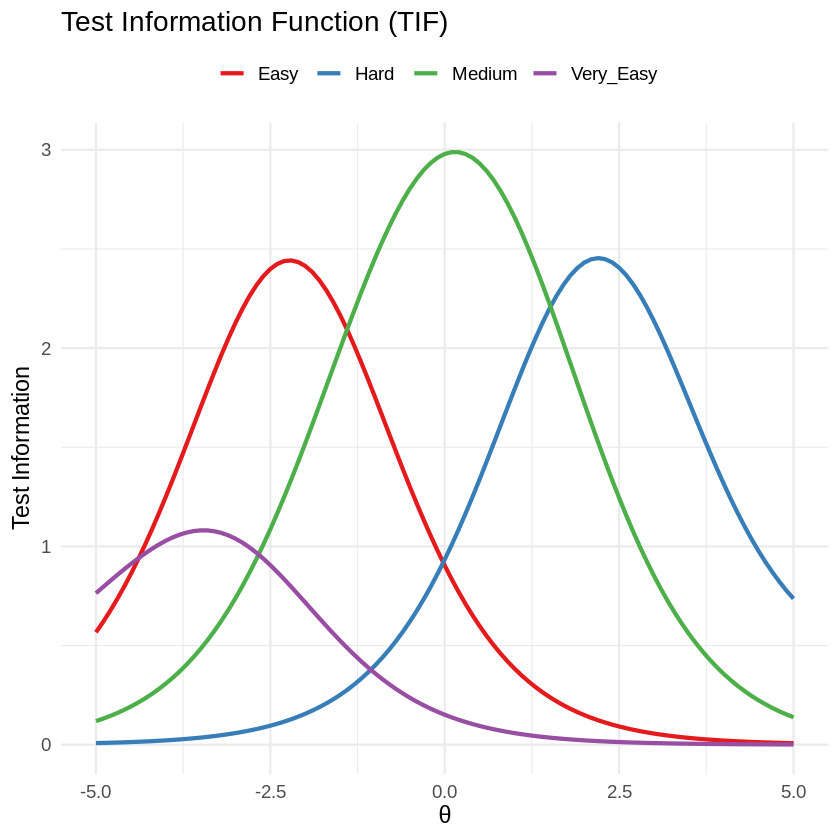

In [59]:
library(tidyr)

# Pivot the TIF data to long format
tif_long <- tif_data %>%
  pivot_longer(cols = -theta, names_to = "Module", values_to = "Information")

# Plot TIFs for each module
ggplot(tif_long, aes(x = theta, y = Information, color = Module)) +
  geom_line(size = 1.2) +
  theme_minimal(base_size = 14) +
  labs(
    title = "Test Information Function (TIF)",
    x = expression(theta),
    y = "Test Information"
  ) +
  scale_color_brewer(palette = "Set1") +
  theme(
    legend.position = "top",
    legend.title = element_blank()
  )


In [60]:
# ============================
# DEFINE MODULES FOR 1–4 MST
# ============================

# Stage 1: Routing module (8 items, medium range -1.5 to 1.5)
routing_items <- c(
  "SP67_correct",
  "SP52_correct",
  "SP37_correct",
  "SP55_correct",
  "SP40_correct",
  "SP64_correct",
  "SP62_correct",
  "SP41_correct"

)

# Stage 2: Very Easy module (5 items b < -3)
very_easy_items <- c(
  "SP33_correct",
  "SP45_correct",
  "SP35_correct",
  "SP65_correct",
  "SP68_correct"
)


# Stage 2: Easy module (5 items b < -1.5)
easy_items <- c(
  "SP46_correct",
  "SP36_correct",
  "SP50_correct",
  "SP47_correct",
  "SP34_correct"
)

# Stage 2: Medium module (5 items, medium range -1.5 to 1.5)
medium_items <- c(
  "SP48_correct",
  "SP44_correct",
  "SP60_correct",
  "SP56_correct",
  "SP72_correct"
)

# Stage 2: Hard module (5 items b > +1.5)
hard_items <- c(
  "SP63_correct",
  "SP54_correct",
  "SP69_correct",
  "SP71_correct",
  "SP43_correct"
)

# Combine all item IDs used
all_items <- unique(c(routing_items, very_easy_items, easy_items,medium_items, hard_items))

# ----------------------------
# MAP b-parameters
# ----------------------------

item_b_map <- setNames(pool_33_72$b, pool_33_72$item_id)
item_b_vector <- item_b_map[all_items]


In [61]:
# Function: Rasch Test Information Function (TIF)
rasch_test_info <- function(theta, b_params) {
  if (length(b_params) == 0) return(rep(0, length(theta)))  # No items = 0 info
  sapply(theta, function(th) {
    info_vals <- sapply(b_params, function(b) {
      p <- 1 / (1 + exp(-(th - b)))
      p * (1 - p)
    })
    sum(info_vals)
  })
}

# Theta range for plotting TIFs
theta_vals <- seq(-4, 4, by = 0.1)

# Get b values per module
b_routing     <- item_b_vector[routing_items]
b_very_easy        <- item_b_vector[very_easy_items]
b_easy        <- item_b_vector[easy_items]
b_medium        <- item_b_vector[medium_items]
b_hard        <- item_b_vector[hard_items]

# Compute TIFs
tif_data <- data.frame(
  theta      = theta_vals,
  Routing    = rasch_test_info(theta_vals, b_routing),
  Very_Easy       = rasch_test_info(theta_vals, b_very_easy),
  Easy       = rasch_test_info(theta_vals, b_easy),
  Medium       = rasch_test_info(theta_vals, b_medium),
  Hard       = rasch_test_info(theta_vals, b_hard)
)

# View first few rows (optional)
head(tif_data)


,theta,Routing,Very_Easy,Easy,Medium,Hard
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,-4.0,0.2133428,1.028519,0.6470527,0.08181154,0.01059439
2,-3.9,0.2334077,1.045364,0.6921202,0.09009101,0.01170320
3,-3.8,0.2551091,1.059294,0.7382688,0.09917164,0.01292743
4,-3.7,0.2785306,1.070017,0.7851644,0.10912307,0.01427896
5,-3.6,0.3037499,1.077272,0.8324168,0.12001928,0.01577086
6,-3.5,0.3308361,1.080830,0.8795811,0.13193846,0.01741749


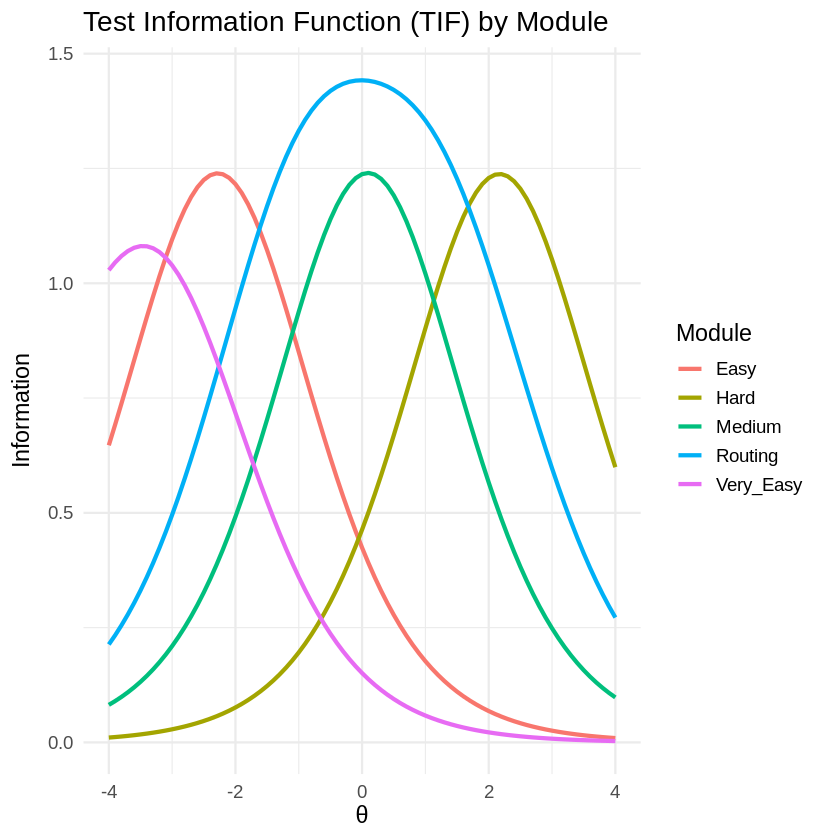

In [62]:
# Convert to long format for ggplot
tif_long <- tif_data %>%
  pivot_longer(cols = -theta, names_to = "Module", values_to = "Information")

# Plot TIFs
ggplot(tif_long, aes(x = theta, y = Information, color = Module)) +
  geom_line(size = 1.2) +
  theme_minimal(base_size = 14) +
  labs(
    title = "Test Information Function (TIF) by Module",
    x = expression(theta),
    y = "Information"
  )


###

In [63]:
# SIMULATION SETTINGS
# ========================================
set.seed(2025)
n_sim <- 100  # number of simulated examinees
theta_pop <- person_info$Theta
theta_pop <- theta_pop[theta_pop > -4 & theta_pop < 4]
sim_theta <- sample(theta_pop, n_sim, replace = TRUE)



In [64]:
set.seed(2025)
simulate_mst_response <- function(theta,
                                   routing_items,
                                   very_easy_items,
                                   easy_items,
                                   medium_items,
                                   hard_items,
                                   item_b_map) {

  # ---- Stage 1: Simulate Routing Module responses ----
  b_routing <- as.numeric(item_b_map[trimws(routing_items)])
  p_routing <- 1 / (1 + exp(-(theta - b_routing)))
  stage1_resp <- rbinom(length(routing_items), 1, p_routing)
  routing_score <- sum(stage1_resp, na.rm = TRUE)

  # ---- Stage 2: Route based on number-correct rule ----
  if (routing_score <= 2) {
    module_items <- very_easy_items
    module_name  <- "Very Easy"
  } else if (routing_score <= 4) {
    module_items <- easy_items
    module_name  <- "Easy"
  } else if (routing_score <= 6) {
    module_items <- medium_items
    module_name  <- "Medium"
  } else {
    module_items <- hard_items
    module_name  <- "Hard"
  }

  # ---- Stage 2: Simulate responses for selected module ----
  b_module <- as.numeric(item_b_map[trimws(module_items)])
  p_module <- 1 / (1 + exp(-(theta - b_module)))
  stage2_resp <- rbinom(length(module_items), 1, p_module)

  # ---- Combine responses ----
  all_resp <- c(stage1_resp, stage2_resp)
  item_names <- c(routing_items, module_items)

  if (length(all_resp) == length(item_names)) {
    names(all_resp) <- item_names
  }

  return(list(
    theta = theta,
    routing_score = routing_score,
    module = module_name,
    responses = all_resp
  ))
}


In [65]:
# Run simulation for all examinees (1–2 MST Design)
response_list <- lapply(sim_theta, simulate_mst_response,
                        routing_items = routing_items,
                        very_easy_items = very_easy_items,
                        easy_items = easy_items,
                        medium_items = medium_items,
                        hard_items = hard_items,
                        item_b_map = item_b_map)



In [66]:
# Find all unique item names used across examinees
all_item_names <- unique(unlist(lapply(response_list, function(x) names(x$responses))))

# Convert response list to structured data frame
response_df <- do.call(rbind, lapply(response_list, function(x) {
  resp_vec <- setNames(rep(NA, length(all_item_names)), all_item_names)
  resp_vec[names(x$responses)] <- x$responses
  c(theta = x$theta, routing_score = x$routing_score, module = x$module, resp_vec)
})) %>%
  as.data.frame(stringsAsFactors = FALSE)

# Coerce numeric columns
response_df$theta <- as.numeric(response_df$theta)
response_df$routing_score <- as.integer(response_df$routing_score)


In [67]:
# Get all unique item names across responses (ensures consistent columns)
all_item_names <- unique(unlist(lapply(response_list, function(x) names(x$responses))))

# Convert response_list to data frame by aligning all item columns
response_df <- bind_rows(lapply(response_list, function(x) {
  # Initialize with all items as NA
  resp_vec <- setNames(as.list(rep(NA, length(all_item_names))), all_item_names)

  # Fill available responses
  matched_items <- names(x$responses)
  resp_vec[matched_items] <- as.list(x$responses)

  # Add theta, routing score, module
  c(
    list(theta_true = x$theta,
         routing_score = x$routing_score,
         module = x$module),
    resp_vec
  )
}))


Theta Recovery:
r = 0.918 | RMSE = 0.808 | Mean Bias = -0.008


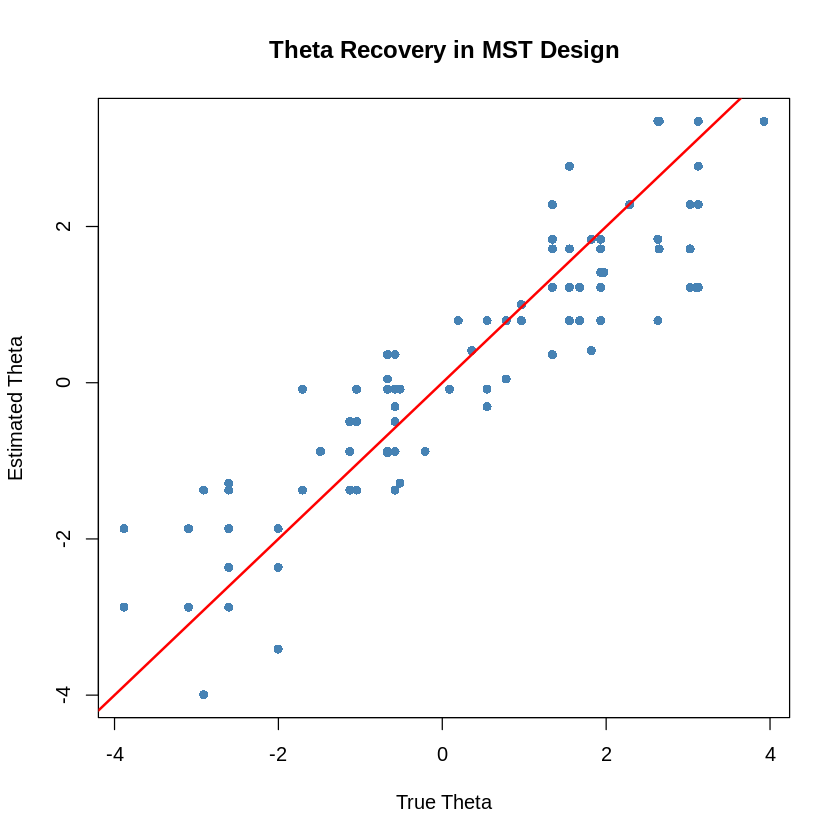

In [68]:

# Step 1: Clean and preprocess
irt_data <- response_df %>%
  select(-theta_true) %>%
  mutate(across(everything(), ~ as.numeric(as.logical(.))))  # Safe 0/1 conversion

# Step 2: Drop items with all NA or no variance
irt_data <- irt_data[, colSums(!is.na(irt_data)) > 0]  # drop all-NA columns
irt_data <- irt_data[, apply(irt_data, 2, function(x) length(unique(na.omit(x))) > 1)]  # drop no-variance items

# Step 3: Drop respondents with all 0s or all 1s
row_sums <- rowSums(irt_data, na.rm = TRUE)
irt_data <- irt_data[row_sums > 0 & row_sums < ncol(irt_data), ]

# Step 4: Align theta_true vector
theta_true_clean <- response_df$theta_true[row_sums > 0 & row_sums < ncol(irt_data)]

# Step 5: Fit Rasch model
model_mst <- mirt(irt_data, 1, itemtype = "Rasch", verbose = FALSE)

# Step 6: Estimate theta
theta_est <- fscores(model_mst, method = "EAP")[, 1]

# Step 7: Evaluation
cor_theta <- cor(theta_true_clean, theta_est, use = "complete.obs")
rmse_theta <- sqrt(mean((theta_est - theta_true_clean)^2, na.rm = TRUE))
mean_bias <- mean(theta_est - theta_true_clean, na.rm = TRUE)

# Step 8: Report
cat("Theta Recovery:\n")
cat(sprintf("r = %.3f | RMSE = %.3f | Mean Bias = %.3f\n", cor_theta, rmse_theta, mean_bias))

# Step 9: Plot
plot(theta_true_clean, theta_est,
     main = "Theta Recovery in MST Design",
     xlab = "True Theta", ylab = "Estimated Theta",
     col = "steelblue", pch = 16)
abline(0, 1, col = "red", lwd = 2)


In [69]:
# ----------------------------------------
# Count how many examinees were routed to each module (1–4 MST design)
# ----------------------------------------

# Extract routed module name from each simulation result
module_routed <- sapply(response_list, function(x) x$module)

# Count how many were routed to each module
routing_distribution <- table(module_routed)

# Print routing distribution
print(routing_distribution)


module_routed
     Easy      Hard    Medium Very Easy 
       17        20        27        36 


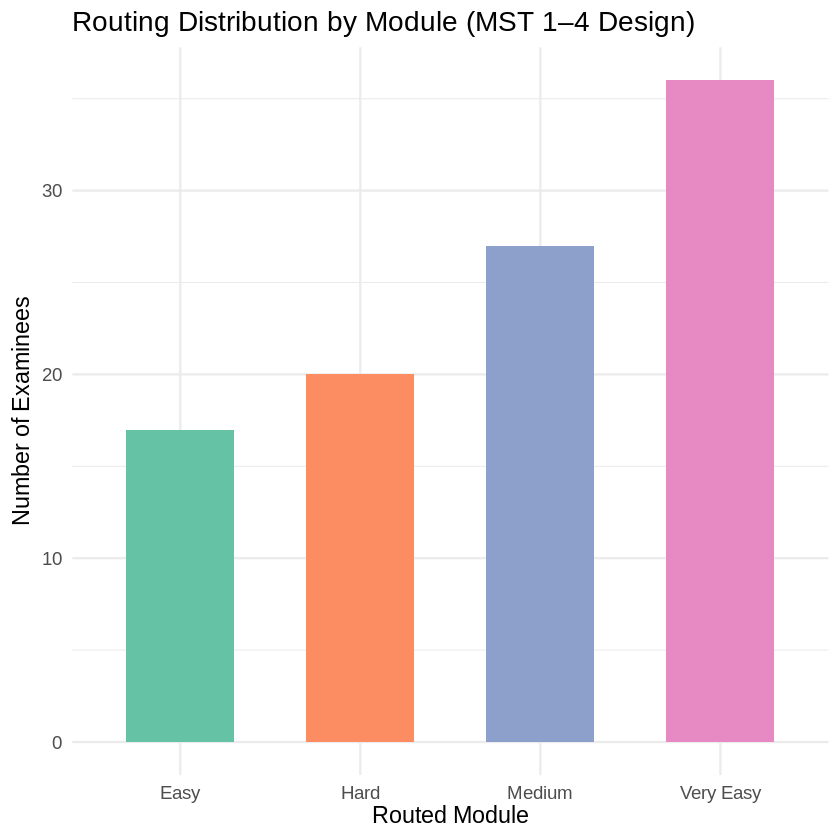

In [70]:
# plot number of modules seen
ggplot(as.data.frame(routing_distribution), aes(x = module_routed, y = Freq, fill = module_routed)) +
  geom_bar(stat = "identity", width = 0.6) +
  labs(title = "Routing Distribution by Module (MST 1–4 Design)",
       x = "Routed Module",
       y = "Number of Examinees") +
  theme_minimal(base_size = 14) +
  scale_fill_brewer(palette = "Set2", name = "Module") +
  theme(legend.position = "none")


In [71]:
summary(item_b_map[very_easy_items])
summary(item_b_map[easy_items])
summary(item_b_map[routing_items])
summary(item_b_map[medium_items])
summary(item_b_map[hard_items])


   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
 -5.299  -3.873  -3.148  -3.682  -3.046  -3.046 

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
 -2.561  -2.385  -2.294  -2.281  -2.125  -2.042 

    Min.  1st Qu.   Median     Mean  3rd Qu.     Max. 
-1.30459 -0.94469  0.04625  0.12310  1.11108  1.69004 

    Min.  1st Qu.   Median     Mean  3rd Qu.     Max. 
-0.11113 -0.07103  0.05153  0.09366  0.27367  0.32526 

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  1.932   2.009   2.206   2.171   2.206   2.502 

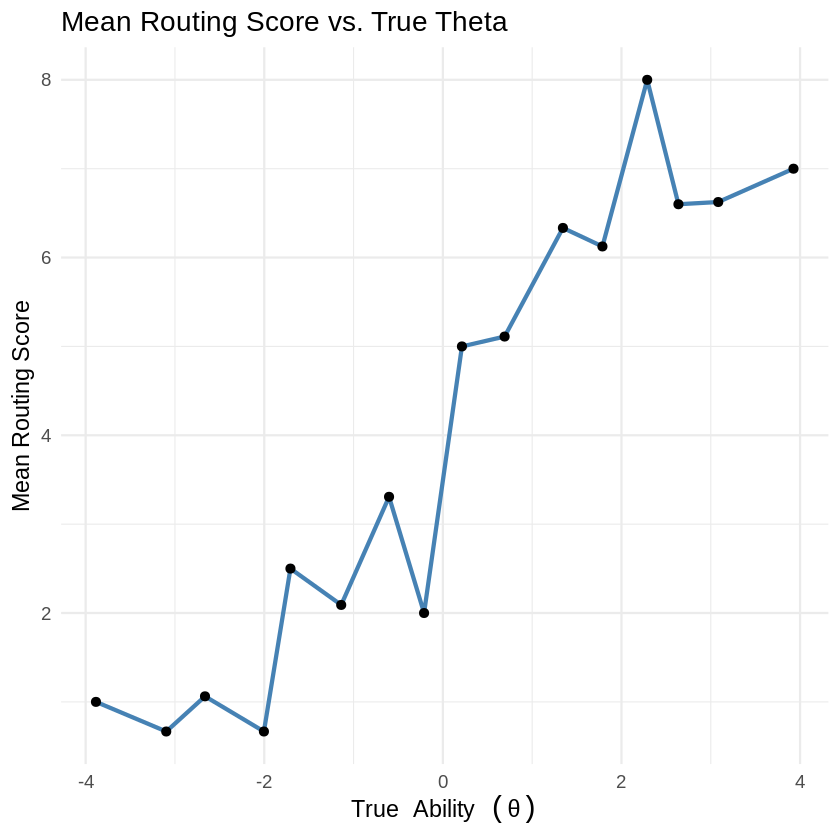

In [72]:
library(dplyr)
library(ggplot2)

# Get routing scores
routing_scores <- sapply(response_list, function(resp) sum(resp$responses[routing_items], na.rm = TRUE))

# Create data frame
df_plot <- data.frame(
  theta = sim_theta,
  routing_score = routing_scores
)

# Optionally bin theta for cleaner lines
df_plot_binned <- df_plot %>%
  mutate(theta_bin = cut(theta, breaks = seq(-4, 4, by = 0.5))) %>%
  group_by(theta_bin) %>%
  summarise(mean_theta = mean(theta),
            mean_routing = mean(routing_score),
            .groups = "drop")

# Plot
ggplot(df_plot_binned, aes(x = mean_theta, y = mean_routing)) +
  geom_line(size = 1.2, color = "steelblue") +
  geom_point(size = 2) +
  labs(
    title = "Mean Routing Score vs. True Theta",
    x = expression(True~Ability~(theta)),
    y = "Mean Routing Score"
  ) +
  theme_minimal(base_size = 14)


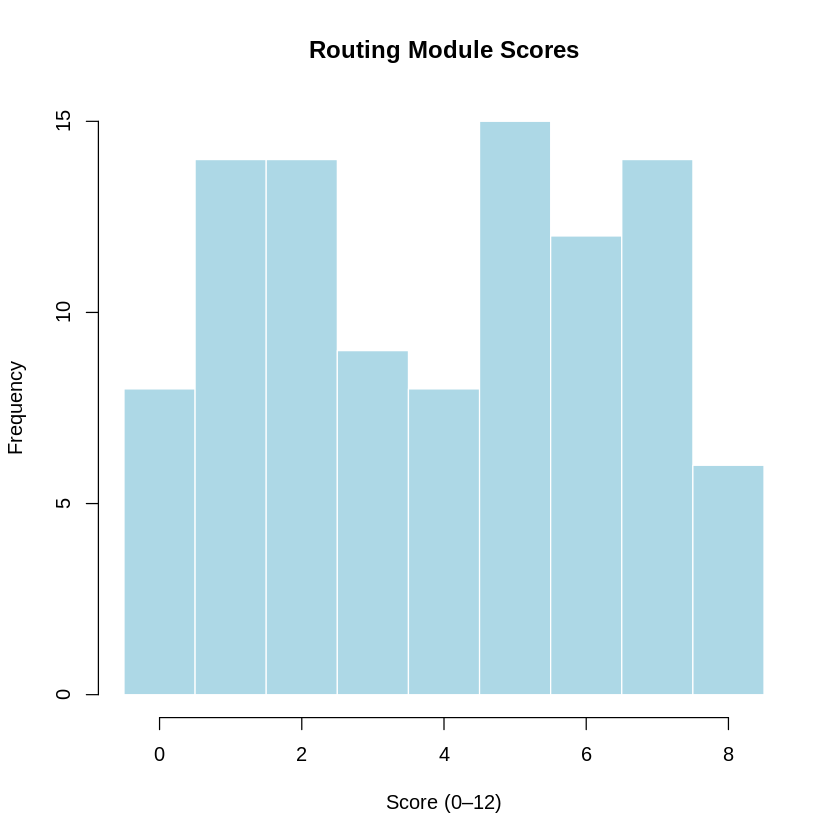

In [73]:
# Determine actual max score
max_score <- max(routing_scores, na.rm = TRUE)

# Plot histogram with appropriate breaks
hist(routing_scores,
     breaks = seq(-0.5, max_score + 0.5, 1),  # dynamic binning
     main = "Routing Module Scores",
     xlab = "Score (0–12)",
     col = "lightblue",
     border = "white")


In [74]:
#install required packages
install.packages("truncnorm")  # Only once
library(truncnorm)


Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



In [75]:
######## SIMULATION WITH 20 TRIALS (1–4 MST DESIGN) ########
# =============== PARAMETERS ===============
set.seed(123)

# =============== PARAMETERS ===============
n_sim <- 10000        # Number of examinees per trial
n_trials <- 20        # Number of simulation trials

# Create results container
results <- data.frame(
  trial = integer(n_trials),
  correlation = numeric(n_trials),
  rmse = numeric(n_trials),
  bias = numeric(n_trials)
)

# =============== SIMULATION FUNCTION ===============
simulate_mst_response <- function(theta,
                                  routing_items,
                                  very_easy_items,
                                  easy_items,
                                  medium_items,
                                  hard_items,
                                  item_b_map) {

  # Stage 1: Routing responses
  b_routing <- as.numeric(item_b_map[trimws(routing_items)])
  p_routing <- 1 / (1 + exp(-(theta - b_routing)))
  stage1_resp <- rbinom(length(routing_items), 1, p_routing)
  routing_score <- sum(stage1_resp)

  # Stage 2: Routing logic (0–8)
  if (routing_score <= 2) {
    module_items <- very_easy_items
    module_name <- "Very Easy"
  } else if (routing_score <= 4) {
    module_items <- easy_items
    module_name <- "Easy"
  } else if (routing_score <= 6) {
    module_items <- medium_items
    module_name <- "Medium"
  } else {
    module_items <- hard_items
    module_name <- "Hard"
  }

  # Stage 2 responses
  b_module <- as.numeric(item_b_map[trimws(module_items)])
  p_module <- 1 / (1 + exp(-(theta - b_module)))
  stage2_resp <- rbinom(length(module_items), 1, p_module)

  # Combine all responses
  all_resp <- c(stage1_resp, stage2_resp)
  item_names <- c(routing_items, module_items)
  names(all_resp) <- item_names

  return(all_resp)
}

# =============== TRIAL LOOP ===============
for (i in 1:n_trials) {
  # Simulate thetas from truncated normal
  sim_theta <- rtruncnorm(n_sim, a = -4, b = 4, mean = 0, sd = 1)

  # Simulate responses
  sim_list <- lapply(sim_theta, simulate_mst_response,
                     routing_items = routing_items,
                     very_easy_items = very_easy_items,
                     easy_items = easy_items,
                     medium_items = medium_items,
                     hard_items = hard_items,
                     item_b_map = item_b_map)

  # Combine and prepare dataset
  response_df <- bind_rows(lapply(sim_list, function(x) as.data.frame(as.list(x))))
  response_df$theta_true <- sim_theta

  # Fit Rasch model
  model <- mirt(response_df %>% select(-theta_true), 1, itemtype = "Rasch", verbose = FALSE)
  theta_est <- fscores(model, method = "EAP")[, 1]
  response_df$theta_est <- theta_est

  # Evaluation metrics
  r     <- cor(response_df$theta_true, theta_est)
  rmse  <- sqrt(mean((response_df$theta_true - theta_est)^2))
  bias  <- mean(theta_est - response_df$theta_true)

  results[i, ] <- c(i, r, rmse, bias)
  cat(sprintf("Trial %2d: r = %.3f | RMSE = %.3f | Bias = %.3f\n", i, r, rmse, bias))
}

# =============== SUMMARY ===============
cat("\n=== 📊 Overall Performance Across Trials ===\n")
print(results)

# Averages
mean_cor  <- mean(results$correlation)
mean_rmse <- mean(results$rmse)
mean_bias <- mean(results$bias)

cat(sprintf("\n🔹 Mean Correlation: %.3f", mean_cor))
cat(sprintf("\n🔹 Mean RMSE: %.3f", mean_rmse))
cat(sprintf("\n🔹 Mean Bias: %.3f\n", mean_bias))

Trial  1: r = 0.819 | RMSE = 0.573 | Bias = 0.002
Trial  2: r = 0.819 | RMSE = 0.577 | Bias = -0.014
Trial  3: r = 0.818 | RMSE = 0.575 | Bias = -0.018
Trial  4: r = 0.820 | RMSE = 0.572 | Bias = 0.009
Trial  5: r = 0.820 | RMSE = 0.578 | Bias = 0.012
Trial  6: r = 0.812 | RMSE = 0.581 | Bias = 0.006
Trial  7: r = 0.816 | RMSE = 0.585 | Bias = -0.004
Trial  8: r = 0.819 | RMSE = 0.575 | Bias = -0.010
Trial  9: r = 0.812 | RMSE = 0.585 | Bias = 0.016
Trial 10: r = 0.811 | RMSE = 0.579 | Bias = 0.010
Trial 11: r = 0.811 | RMSE = 0.581 | Bias = 0.008
Trial 12: r = 0.818 | RMSE = 0.574 | Bias = -0.008
Trial 13: r = 0.818 | RMSE = 0.575 | Bias = 0.017
Trial 14: r = 0.822 | RMSE = 0.562 | Bias = -0.003
Trial 15: r = 0.818 | RMSE = 0.580 | Bias = -0.001
Trial 16: r = 0.817 | RMSE = 0.581 | Bias = 0.018
Trial 17: r = 0.817 | RMSE = 0.575 | Bias = 0.011
Trial 18: r = 0.814 | RMSE = 0.571 | Bias = -0.010
Trial 19: r = 0.817 | RMSE = 0.577 | Bias = -0.003
Trial 20: r = 0.815 | RMSE = 0.580 | Bias

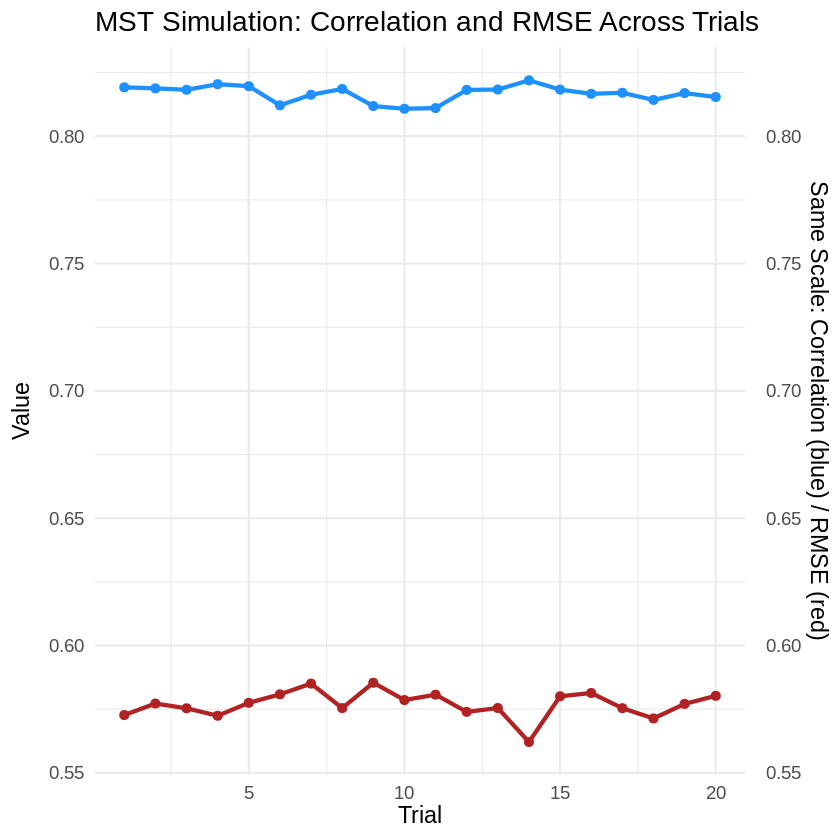

In [76]:

ggplot(results, aes(x = trial)) +
  geom_line(aes(y = correlation), color = "dodgerblue", size = 1.2) +
  geom_point(aes(y = correlation), color = "dodgerblue", size = 2) +
  geom_line(aes(y = rmse), color = "firebrick", size = 1.2) +
  geom_point(aes(y = rmse), color = "firebrick", size = 2) +
  scale_y_continuous(
    name = "Value",
    sec.axis = sec_axis(~ ., name = "Same Scale: Correlation (blue) / RMSE (red)")
  ) +
  labs(title = "MST Simulation: Correlation and RMSE Across Trials",
       x = "Trial") +
  theme_minimal(base_size = 14)

